In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seawater
import xarray as xr
import scipy.signal as sp
import pandas as pd

%matplotlib inline

# Potential sub-surface channel
This notebook will contain the update as we step forward implementing the **Potential Sub-surface** acoustic variable.It is a boolean that indicates the potential existence of a sub-surface sound channel. 

>*A sub-surface sound channel can exist if there are two local minima in the sound speed profile above 1000 m.*

### Importing a sample profile

In [387]:
#profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T16_45_30.510267.csv", comment='/') 
profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-02-01T16 14 10.909373_require_feedback.csv", header=2) 

In [388]:
profile.columns

Index(['Latitude', 'Longitude', 'Depth (m)', 'Pressure', 'Salinity',
       'Temperature', 'Sound Speed'],
      dtype='object')

In [389]:
profile_depth_sspeed = profile[['Sound Speed', 'Depth (m)']] # extracting only the soundspeed and depth column
profile_depth_sspeed = profile_depth_sspeed[profile_depth_sspeed ['Depth (m)'] < 1000] #taking only the rows where depth < 1000
profile_depth_sspeed


,Sound Speed,Depth (m)
0,1467.3,0.5
1,1467.3,1.5
2,1467.3,2.6
3,1467.3,3.8
4,1467.3,5.1
5,1467.3,6.4
6,1467.4,7.9
7,1467.4,9.6
8,1467.4,11.4
9,1467.4,13.5


Text(0.5, 0, 'Speed of sound [m/s]')

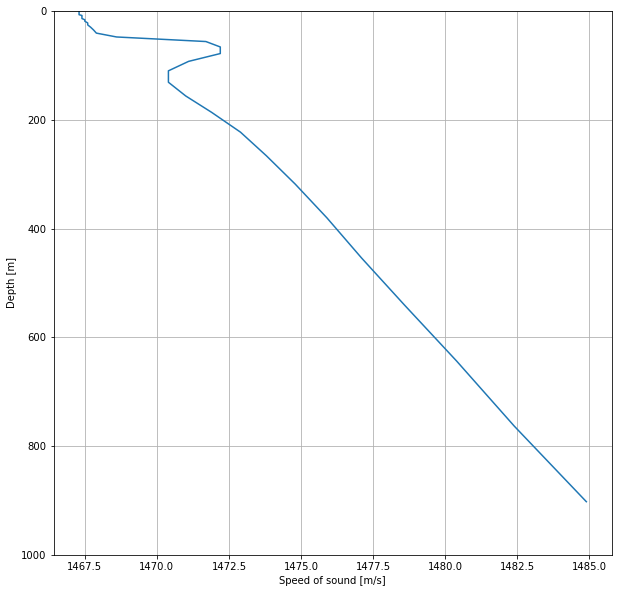

In [390]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')

Using the *find_peaks()* function from *scipy.signal* to detect the localminima

In [391]:
profile_np = np.array(profile_depth_sspeed['Sound Speed'])
local_minima = sp.find_peaks(-profile_np) # get the index array of local minima
local_minima =local_minima[0]
local_maxima = sp.find_peaks(profile_np) # get the index array of the local maxima
local_maxima = local_maxima[0]


Plotting the returned minima and maxima on the sound speed profile plot.

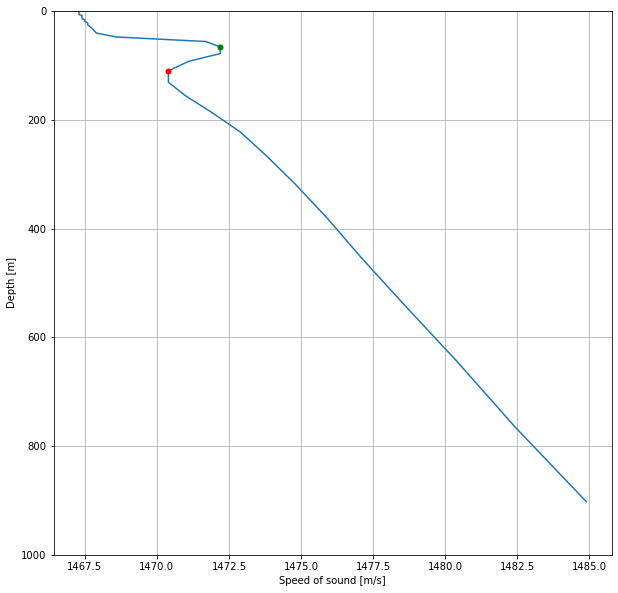

In [392]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(profile_depth_sspeed['Sound Speed'][local_minima],profile_depth_sspeed['Depth (m)'][local_minima],'r.',markersize=10)
ax.plot(profile_depth_sspeed['Sound Speed'][local_maxima],profile_depth_sspeed['Depth (m)'][local_maxima],'g.',markersize=10)

#### Checking if array *local_minima* has 2 or more minima
    - If yes, The difference in sound speed between the local maxima and the first local minimum must be greater than 5 m/s.
       
       If two local minima exist but only one local maximum exists then
   
            - The difference in the speed of sound at the surface and the first local minimum is greater than 5 m/s and the difference between the speed of sound at the local minimum and     local maximum is greater than 5 m/s.

Followed this file for reference.
https://github.com/DFO-Ocean-Navigator/Ocean-Data-Map-Project/blob/master/data/calculated_parser/functions.py

In [395]:
has_PSSC = 0
# Need to 
sound_speed = profile_depth_sspeed['Sound Speed']
depth = profile_depth_sspeed['Depth (m)']
if len(local_minima)>=2: #if there are 2 or more minima
    p1 = 0 # surface
    p2 = local_minima[0] #first minimum
    if len(local_maxima)>=2: # if there are more than one maxima
        p1 = local_maxima[0] #first maximum
        p3 = local_maxima[1] #second maximum
    else: #only one local maximum
        p3 =  local_maxima[0] 
        if p3 < p2: # the only one maxima is higher in the water column than the minima
            has_PSSC=0
    print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
    p1_sound_speed = sound_speed[p1]
    p2_sound_speed = sound_speed[p2]
    p3_sound_speed = sound_speed[p3]
    
    c1 = abs(p1_sound_speed-p2_sound_speed) 
    c2 = abs(p3_sound_speed-p2_sound_speed)
    print("c1 = "+ str(c1) +"m/s")
    print("c2 = "+ str(c2) +"m/s")
    
    if c1>5 and c2>5:
        has_PSSC =1
    else:
        has_PSSC =0
else:
    has_PSSC =0 

print("Value of Potential sub-surface channel :" + str(has_PSSC))

Value of Potential sub-surface channel :0


Displaying the c1 and c2 in the plot

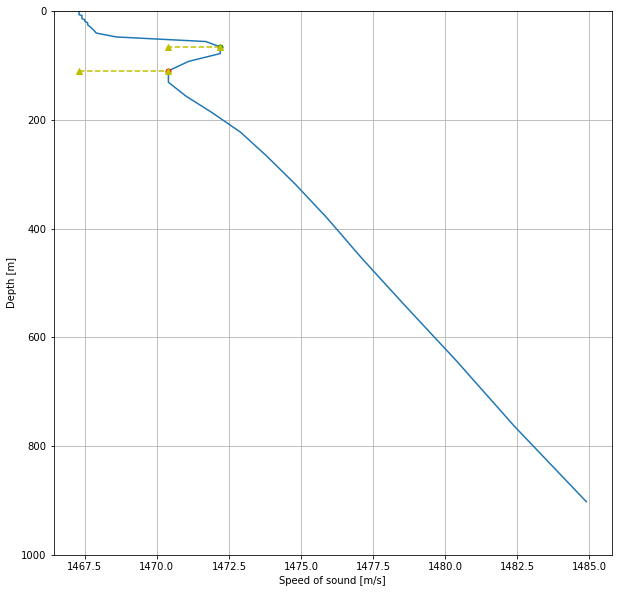

In [397]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(sound_speed,depth)
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(sound_speed[local_minima],depth[local_minima],'r.',markersize=10)
ax.plot(sound_speed[local_maxima],depth[local_maxima],'g.',markersize=10)
#plotting c1
x_p1p2 = [sound_speed[i] for i in [p1,p2]]
y_p1p2 = [depth[i] for i in [p2,p2]]
ax.plot(x_p1p2, y_p1p2, 'y^--',label= "c1")
#plotting c2
x_p3p2 = [sound_speed[i] for i in [p3,p2]]
y_p3p2 = [depth[i] for i in [p3,p3]]
ax.plot(x_p3p2, y_p3p2, 'y^--',label= "c2")

## Refactoring the steps inside a function
The steps to find the potential sub-surface channel is refactored in a function below. 

In [368]:
"""
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
"""
def detect_potential_sub_surface_channel(depth, sspeed)-> bool:
    has_PSSC = 0
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    sspeed = sspeed[0:(len(depth))]
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sspeed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sspeed)[0] # get the index array of local maxima
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1>5 and c2>5:
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC

In [369]:
depth = profile['Depth (m)']
sspeed = profile['Sound Speed']
detect_potential_sub_surface_channel(depth, sspeed)

p1 p2 p3 : 16 20 25


1

## Next steps
Test this code using some profiles from Navigator
- ~~Refactor the code into a single method (what will be the inputs in that case?)~~
- ~~Find 5 profiles that will have a sub-surface channel (will return 1)~~
- ~~Find 5 profiles where sub-surface channel exists (will return 0)~~
- Verify that this algorithm works
- Display all positive sound profiles' plot, as well as the negative ones.
- 


### Modification Planned to integrate frequency cutoff 
The previously stated definition of sub-surface channel used a constant value 5 m/s to compare the distance between the maxima and the minima. That 5 m/s value is 	&#916;C in the following image, which is the difference between **first minima** and **first maxima**.

![Sound Channel](images/SoundChannel.jpg)

&#916;C is dependent on C<sub>min</sub> (Local Minima on the first negative gradient), &#916;Z (Channel Width) which can be calculated from the sound profile. And we have to use a fixed value of f<sub>cutoff</sub> when we calculate &#916;C. **This fixed value of f<sub>cutoff</sub>  will indicate the minimum frequency of sound that will be trapped in that sub-surface sound channel**

#### Question 
Are we intending to calculate the $\beta$

![Frequency cut off Equation](images/eqn.jpg)